In [105]:
from pathlib import Path
import pickle
import shutil
import numpy as np
import torch

import transforms3d

import colmap as colmap_utils
import open3d as o3d
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
# this is code that used for refine colmap scale given depth image, if you can have depth image, you can use this code to refine colmap scale 
# this can help to skip the scale refinement step in data preprocessing


# thanks to zirui wu for providing this code

In [2]:
datadir = Path("/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/")
cameras = ["FRONT", "FRONT_LEFT", "FRONT_RIGHT", "SIDE_LEFT", "SIDE_RIGHT"]

metapath = datadir / "scenario.pt"
assert datadir.exists() and metapath.exists(), "Invalid data directory"

images_dir = datadir / "images"

In [3]:
with open(metapath, "rb") as f:
    meta = pickle.load(f)

### Generate Initial Sparse Model for Colmap

In [17]:
colmap_dir = datadir / "colmap"
if colmap_dir.exists():
    # delete existing colmap directory
    shutil.rmtree(colmap_dir)
colmap_dir.mkdir(parents=True)
sparse_initial_folder = colmap_dir / "sparse" / "initial"
colmap_images_dir = colmap_dir / "images"
camera_txt_path = sparse_initial_folder / "cameras.txt"
points3d_txt_path = sparse_initial_folder / "points3D.txt"
images_txt_path = sparse_initial_folder / "images.txt"

sparse_initial_folder.mkdir(parents=True)

shutil.copytree(src=images_dir, dst=colmap_images_dir)

PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/images')

In [26]:
camera_intrinsics = {}
camera_with_images_dict = {}
frame_idx = 0

for camera_idx, camera in enumerate(cameras):
    camera_image_dir = colmap_images_dir / f"camera_{camera}"
    image_paths = []
    camera_extrinsics = []
    colmap_images = []
    for i, image_filename in enumerate(sorted(camera_image_dir.iterdir())):
        image_id = len(image_paths)
        image_paths.append(f"camera_{camera}/{image_filename.name}")

        if i == 0:
            colmap_camera = colmap_utils.Camera(
                camera_index=camera_idx,
                model=colmap_utils.CameraModels.OPENCV,
                height=meta["observers"][f"camera_{camera}"]["data"]["hw"][i][0],
                width=meta["observers"][f"camera_{camera}"]["data"]["hw"][i][1],
                camera_name=f"camera_{camera}",
                parameters=[
                    meta["observers"][f"camera_{camera}"]["data"]["intr"][i][0, 0], # fx
                    meta["observers"][f"camera_{camera}"]["data"]["intr"][i][1, 1], # fy
                    meta["observers"][f"camera_{camera}"]["data"]["intr"][i][0, 2], # cx
                    meta["observers"][f"camera_{camera}"]["data"]["intr"][i][1, 2], # cy
                    meta["observers"][f"camera_{camera}"]["data"]["distortion"][i][0], # k1
                    meta["observers"][f"camera_{camera}"]["data"]["distortion"][i][1], # k2
                    meta["observers"][f"camera_{camera}"]["data"]["distortion"][i][2], # p1
                    meta["observers"][f"camera_{camera}"]["data"]["distortion"][i][3], # p2
                ]
            )
            camera_intrinsics[camera] = colmap_camera
            print(colmap_camera)
        
        c2w = meta["observers"][f"camera_{camera}"]["data"]["c2w"][i]   # already in opencv format
        w2c = np.linalg.inv(c2w)
        trans = w2c[:3, 3]
        quat = transforms3d.quaternions.mat2quat(w2c[:3, :3])
        colmap_image = colmap_utils.Image(
            frame_index=frame_idx,
            quaternion=quat,
            translation=trans,
            camera_index=camera_idx,
            image_filename=image_paths[-1],
        )
        frame_idx = frame_idx + 1
        colmap_images.append(colmap_image)
    
    camera_with_images = colmap_utils.CameraWithImages(
        camera=camera_intrinsics[camera],
        images=colmap_images,
    )
    camera_with_images_dict[camera] = camera_with_images
        
        

Camera(camera_index=0, model='OPENCV', height=1280, width=1920, parameters=[2051.2890018649614, 2051.2890018649614, 950.5540709432578, 647.1451065851895, 0.041666872293357936, -0.32014388957937295, -3.424278982306954e-05, -3.302112356050158e-05], camera_name='camera_FRONT')
Camera(camera_index=1, model='OPENCV', height=1280, width=1920, parameters=[2070.649595587731, 2070.649595587731, 967.9298852513956, 633.7976294123882, 0.046038459140347265, -0.35434273215644013, 0.0009243836643774946, 0.0013362713002997668], camera_name='camera_FRONT_LEFT')
Camera(camera_index=2, model='OPENCV', height=1280, width=1920, parameters=[2049.6550545363402, 2049.6550545363402, 954.086746858901, 654.7370200586179, 0.04789293200871604, -0.3176799395929242, 0.001360951229053503, -0.002172927121293594], camera_name='camera_FRONT_RIGHT')
Camera(camera_index=3, model='OPENCV', height=886, width=1920, parameters=[2047.3261686384708, 2047.3261686384708, 971.3171286955035, 238.56071341987558, 0.043207488477612986

In [27]:
# write cameras.txt
camera_txt_lines = [camera_with_images.camera.to_camera_txt_line() for camera_with_images in camera_with_images_dict.values()]
with open(camera_txt_path, "w") as f:
    f.writelines("\n".join(camera_txt_lines) + "\n")

# write images.txt
images_txt = []
for camera_with_images in camera_with_images_dict.values():
    for image in camera_with_images.images:
        images_txt.append(image.to_image_txt_line() + "\n")
with open(images_txt_path, "w") as f:
    f.write("\n".join(images_txt) + "\n")
    
# write points3D.txt
with open(points3d_txt_path, "w") as f:
    f.write("")

### Run COLMAP

In [20]:
runner = colmap_utils.ColmapRunner(colmap_project_path=str(colmap_dir), run_colmap_func=colmap_utils.run_colmap, mask_path=datadir / "binary_masks")
# runner.run_colmap(
#     dense=False,
#     initial_sparse_model_folderpath=str(sparse_initial_folder),
#     image_undistord=False,
#     refine=True,
#     refine_config=colmap_utils.RefineConfig(
#         refine_focal_length=True,
#         refine_principal_point=False,
#         refine_extra_params=False,
#         refine_extrinsics=True,
#     )
# )
runner.feature_extractor(cameras_model=colmap_utils.CameraModels.OPENCV)

['colmap', 'feature_extractor', '--database_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/database.db'), '--image_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/images'), '--ImageReader.mask_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/binary_masks'), '--ImageReader.single_camera', '0', '--ImageReader.camera_model', 'OPENCV', '--ImageReader.single_camera_per_folder', '1', '--SiftExtraction.use_gpu', '1', '--SiftExtraction.estimate_affine_shape', '1', '--SiftExtraction.domain_size_pooling', '1']


W0423 21:47:57.069283 3299768 feature_extraction.cc:404] Your current options use the maximum number of threads on the machine to extract features. Extracting SIFT features on the CPU can consume a lot of RAM per thread for large images. Consider reducing the maximum image size and/or the first octave or manually limit the number of extraction threads. Ignore this warning, if your machine has sufficient memory for the current settings.
I0423 21:47:57.072846 3299788 misc.cc:198] 
Feature extraction
I0423 21:48:00.569448 3299829 feature_extraction.cc:255] Processed file [1/995]
I0423 21:48:00.569481 3299829 feature_extraction.cc:258]   Name:            camera_FRONT/00000000.jpg
I0423 21:48:00.569484 3299829 feature_extraction.cc:284]   Dimensions:      1920 x 1280
I0423 21:48:00.569486 3299829 feature_extraction.cc:287]   Camera:          #1 - OPENCV
I0423 21:48:00.569489 3299829 feature_extraction.cc:290]   Focal Length:    2304.00px
I0423 21:48:00.569495 3299829 feature_extraction.cc:3

0

In [21]:
runner.feature_matcher()

['colmap', 'exhaustive_matcher', '--database_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/database.db'), '--SiftMatching.use_gpu', '1', '--SiftMatching.guided_matching', '1']


I0423 21:52:11.437192 3299971 misc.cc:198] 
Exhaustive feature matching
I0423 21:52:11.513345 3299971 feature_matching.cc:234] Matching block [1/20, 1/20]
I0423 21:52:13.439635 3299971 feature_matching.cc:47]  in 1.926s
I0423 21:52:13.441373 3299971 feature_matching.cc:234] Matching block [1/20, 2/20]
I0423 21:52:14.406834 3299971 feature_matching.cc:47]  in 0.965s
I0423 21:52:14.407220 3299971 feature_matching.cc:234] Matching block [1/20, 3/20]
I0423 21:52:15.448344 3299971 feature_matching.cc:47]  in 1.041s
I0423 21:52:15.448549 3299971 feature_matching.cc:234] Matching block [1/20, 4/20]
I0423 21:52:17.282250 3299971 feature_matching.cc:47]  in 1.834s
I0423 21:52:17.282444 3299971 feature_matching.cc:234] Matching block [1/20, 5/20]
I0423 21:52:18.278836 3299971 feature_matching.cc:47]  in 0.996s
I0423 21:52:18.279042 3299971 feature_matching.cc:234] Matching block [1/20, 6/20]
I0423 21:52:19.814811 3299971 feature_matching.cc:47]  in 1.536s
I0423 21:52:19.815017 3299971 feature_ma

0

In [28]:
runner.triangulator()

['colmap', 'point_triangulator', '--database_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/database.db'), '--image_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/images'), '--input_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/sparse/initial'), '--output_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/sparse/triangulated'), '--Mapper.ba_global_max_num_iterations', '100', '--Mapper.ba_global_max_refinements', '5', '--Mapper.ba_local_max_refinements', '3', '--Mapper.ba_global_images_ratio', '1.3999999999999999', '--Mapper.ba_global_points_ratio', '1.3999999999999999']


I0423 22:04:03.569890 3301680 misc.cc:198] 
Loading model
I0423 22:04:03.586917 3301680 incremental_mapper.cc:225] Loading database
I0423 22:04:03.588061 3301680 database_cache.cc:54] Loading cameras...
I0423 22:04:03.588083 3301680 database_cache.cc:64]  5 in 0.000s
I0423 22:04:03.588089 3301680 database_cache.cc:72] Loading matches...
I0423 22:04:03.709915 3301680 database_cache.cc:78]  58668 in 0.122s
I0423 22:04:03.709936 3301680 database_cache.cc:94] Loading images...
I0423 22:04:03.837883 3301680 database_cache.cc:144]  995 in 0.128s (connected 995)
I0423 22:04:03.838059 3301680 database_cache.cc:155] Building correspondence graph...
I0423 22:04:04.765689 3301680 database_cache.cc:192]  in 0.928s (ignored 0)
I0423 22:04:04.769968 3301680 timer.cc:91] Elapsed time: 0.020 [minutes]
I0423 22:04:04.834602 3301680 incremental_mapper.cc:546] Iterative triangulation
I0423 22:04:04.834615 3301680 incremental_mapper.cc:552] Triangulating image #1 (0)
I0423 22:04:04.834620 3301680 incremen

0

In [29]:
refine_config=colmap_utils.RefineConfig(
    refine_focal_length=True,
    refine_principal_point=False,
    refine_extra_params=False,
    refine_extrinsics=True,
)

return_code = runner.bundle_adjuster(
    input_sparse_model_folderpath=runner.sparse_model_triangulated_folderpath, refine_config=refine_config
)
runner.sparse_model_final_folderpath = runner.sparse_model_refined_folderpath
return_code

['colmap', 'bundle_adjuster', '--input_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/sparse/triangulated'), '--BundleAdjustment.refine_focal_length', 'True', '--BundleAdjustment.refine_principal_point', 'False', '--BundleAdjustment.refine_extra_params', 'False', '--BundleAdjustment.refine_extrinsics', 'True', '--output_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/sparse/refined')]


I0423 22:06:39.978605 3301896 misc.cc:198] 
Global bundle adjustment
W0423 22:07:51.149912 3301896 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: CHOLMOD warning: Matrix not positive definite.
W0423 22:07:55.390266 3301896 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: CHOLMOD warning: Matrix not positive definite.
W0423 22:07:57.423110 3301896 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: CHOLMOD warning: Matrix not positive definite.
W0423 22:08:02.251818 3301896 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: CHOLMOD warning: Matrix not positive definite.
W0423 22:08:04.724916 3301896 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: CHOLMOD warning: Matrix not positive definite.
W0423 22:08:07.962920 3301896 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: 

0

In [31]:
runner.image_undistorter(input_sparse_model_folderpath=runner.sparse_model_final_folderpath)
runner.sparse_model_final_folderpath = runner.sparse_model_undistord_folderpath

['colmap', 'image_undistorter', '--image_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/images'), '--input_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/sparse/refined'), '--output_path', PosixPath('/home/wuzr/data/waymo/v1/segment-11454085070345530663_1905_000_1925_000_with_camera_labels/colmap/dense')]


I0423 22:10:39.221972 3302103 misc.cc:198] 
Reading reconstruction
I0423 22:10:39.593102 3302103 image.cc:343] => Reconstruction with 995 images and 357864 points
I0423 22:10:39.593132 3302103 misc.cc:198] 
Image undistortion
I0423 22:10:39.596130 3302103 undistortion.cc:214] Undistorting image [1/995]
I0423 22:10:39.828873 3302103 undistortion.cc:214] Undistorting image [2/995]
I0423 22:10:39.828940 3302103 undistortion.cc:214] Undistorting image [3/995]
I0423 22:10:39.875476 3302103 undistortion.cc:214] Undistorting image [4/995]
I0423 22:10:39.875500 3302103 undistortion.cc:214] Undistorting image [5/995]
I0423 22:10:39.875504 3302103 undistortion.cc:214] Undistorting image [6/995]
I0423 22:10:39.875506 3302103 undistortion.cc:214] Undistorting image [7/995]
I0423 22:10:39.875507 3302103 undistortion.cc:214] Undistorting image [8/995]
I0423 22:10:39.875509 3302103 undistortion.cc:214] Undistorting image [9/995]
I0423 22:10:39.875511 3302103 undistortion.cc:214] Undistorting image [1

In [38]:
ply_filepath = create_ply_from_colmap(runner,
    runner.sparse_model_final_folderpath, output_dir=runner.colmap_project_path
)
runner.output_point_cloud_filepath = ply_filepath

In [40]:
refined_colmap_dir = colmap_dir / "sparse" / "refined"
assert refined_colmap_dir.exists(), "Refined colmap directory not found"

In [184]:
from colmap_read_write_model import read_images_binary, read_cameras_binary, read_points3D_binary

refined_colmap_images = read_images_binary(refined_colmap_dir / "images.bin")
refined_colmap_cameras = read_cameras_binary(refined_colmap_dir / "cameras.bin")
refined_colmap_points3d = read_points3D_binary(refined_colmap_dir / "points3D.bin")

In [66]:
refined_colmap_cameras[0], refined_colmap_images[1]

(Camera(id=0, model='OPENCV', width=1920, height=1280, params=array([ 2.05540464e+03,  2.10757542e+03,  9.50554071e+02,  6.47145107e+02,
         4.16668723e-02, -3.20143890e-01, -3.42427898e-05, -3.30211236e-05])),
 Image(id=1, qvec=array([ 0.00701733,  0.01133489, -0.70551954,  0.70856507]), tvec=array([-0.21259845,  2.28272261,  1.105494  ]), camera_id=0, name='camera_FRONT/00000000.jpg', xys=array([[ 123.51131439,  784.27008057],
        [  59.63265228,  614.70574951],
        [ 443.73406982,  639.75201416],
        ...,
        [1618.33752441,  720.32012939],
        [1166.88623047,  445.64505005],
        [ 924.01202393,  547.22314453]]), point3D_ids=array([   -1,    -1,    -1, ...,  2100,    -1, 19011])))

In [92]:
image_name = refined_colmap_images[1].name
camera = image_name.split("/")[0].split("_")[1]
image_idx = int(image_name.split("/")[1].split(".")[0])
old_colmap_image = camera_with_images_dict[camera].images[image_idx]
assert old_colmap_image.image_filename == image_name

old_intrinsics = np.eye(3)
old_intrinsics[0, 0] = camera_with_images_dict[camera].camera.parameters[0]
old_intrinsics[1, 1] = camera_with_images_dict[camera].camera.parameters[1]
old_intrinsics[0, 2] = camera_with_images_dict[camera].camera.parameters[2]
old_intrinsics[1, 2] = camera_with_images_dict[camera].camera.parameters[3]

old_w2c = np.eye(4)
old_w2c[:3, :3] = transforms3d.quaternions.quat2mat(old_colmap_image.quaternion)
old_w2c[:3, 3] = old_colmap_image.translation

old_colmap_image.quaternion, old_colmap_image.translation, refined_colmap_images[1].qvec, refined_colmap_images[1].tvec

(array([ 0.00722607,  0.01137768, -0.70569108,  0.70839144]),
 array([-0.05316629,  2.11103087, -1.54904055]),
 array([ 0.00701733,  0.01133489, -0.70551954,  0.70856507]),
 array([-0.21259845,  2.28272261,  1.105494  ]))

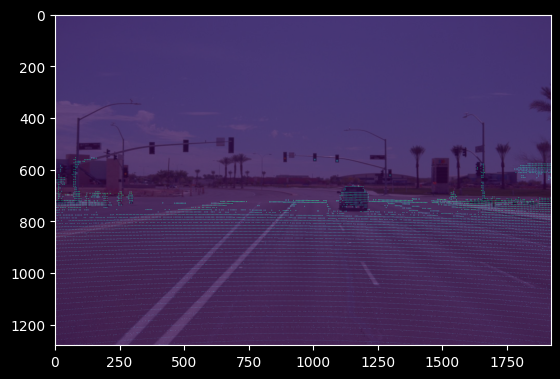

In [125]:
new_w2c = np.eye(4)
new_w2c[:3, :3] = transforms3d.quaternions.quat2mat(refined_colmap_images[1].qvec)
new_w2c[:3, 3] = refined_colmap_images[1].tvec
new_c2w = np.linalg.inv(new_w2c)

new_intrinsics = np.eye(3)
new_intrinsics[0, 0] = refined_colmap_cameras[refined_colmap_images[1].camera_id].params[0]
new_intrinsics[1, 1] = refined_colmap_cameras[refined_colmap_images[1].camera_id].params[1]
new_intrinsics[0, 2] = refined_colmap_cameras[refined_colmap_images[1].camera_id].params[2]
new_intrinsics[1, 2] = refined_colmap_cameras[refined_colmap_images[1].camera_id].params[3]

lidar_depth_path = datadir / "lidar_depth_maps" / f"camera_{camera}" / f"{image_idx:08d}.png"
image_path = images_dir / image_name
assert lidar_points_old_path.exists() and image_path.exists()

old_depth_np = np.array(Image.open(lidar_depth_path))
plt.imshow(old_depth_np, vmax=655.35)
image = Image.open(image_path)
plt.imshow(image, alpha=0.5)

In [109]:
pt_ids = np.where(refined_colmap_images[1].point3D_ids > -1)[0]
pt_ids

array([   8,   12,   17, ..., 2926, 2935, 2937])

In [110]:
refined_colmap_points3d[1]

Point3D(id=1, xyz=array([  69.08015087, -257.60243526,    4.51622456]), rgb=array([29, 34, 28]), error=array(1.34346661), image_ids=array([36, 39, 30, 33, 44]), point2D_idxs=array([2, 0, 3, 4, 1]))

In [149]:
points3d_np = np.array([point3d.xyz for point3d in refined_colmap_points3d.values()])
points_rgb_np = np.array([point3d.rgb for point3d in refined_colmap_points3d.values()])
points3d_np.shape, points_rgb_np.shape

((357864, 3), (357864, 3))

[029:939][3333787] (port.cc:379): Port[9403f470:0:1:0:local:Net[wlo1:10.5.140.x/22:Unknown:id=5]]: Received non-STUN packet from unknown address: 222.130.139.x:35783
[029:983][3333787] (port.cc:379): Port[94009ee0:0:1:0:local:Net[enp4s0:10.5.4.x/22:Unknown:id=1]]: Received non-STUN packet from unknown address: 222.130.139.x:35783
[030:044][3333787] (port.cc:379): Port[94040f40:0:1:0:local:Net[utun:198.18.0.x/16:VPN/Unknown:id=4]]: Received non-STUN packet from unknown address: 74.125.250.x:35783
[030:117][3333787] (port.cc:379): Port[94009ee0:0:1:0:local:Net[enp4s0:10.5.4.x/22:Unknown:id=1]]: Received non-STUN packet from unknown address: 218.200.111.x:53968
[030:175][3333787] (port.cc:379): Port[94040f40:0:1:0:local:Net[utun:198.18.0.x/16:VPN/Unknown:id=4]]: Received non-STUN packet from unknown address: 74.125.250.x:53968


In [145]:
points3d_np[pt_ids].shape

(1147, 3)

(1280, 1920, 1) 0.0 467382.2


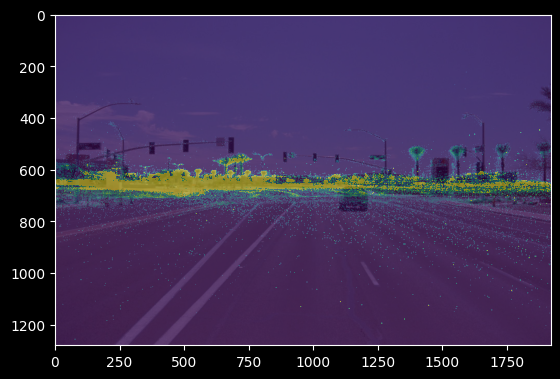

[149:964][3333787] (port.cc:379): Port[9403f470:0:1:0:local:Net[wlo1:10.5.140.x/22:Unknown:id=5]]: Received non-STUN packet from unknown address: 49.83.32.x:1351
[149:968][3333787] (port.cc:379): Port[9403f470:0:1:0:local:Net[wlo1:10.5.140.x/22:Unknown:id=5]]: Received non-STUN packet from unknown address: 117.66.169.x:1050
[149:970][3333787] (port.cc:379): Port[9403f470:0:1:0:local:Net[wlo1:10.5.140.x/22:Unknown:id=5]]: Received non-STUN packet from unknown address: 222.130.139.x:35783
[149:973][3333787] (port.cc:379): Port[9403f470:0:1:0:local:Net[wlo1:10.5.140.x/22:Unknown:id=5]]: Received non-STUN packet from unknown address: 223.68.189.x:53121
[149:973][3333787] (port.cc:379): Port[9403f470:0:1:0:local:Net[wlo1:10.5.140.x/22:Unknown:id=5]]: Received non-STUN packet from unknown address: 112.32.119.x:28783
[149:978][3333787] (port.cc:379): Port[9403f470:0:1:0:local:Net[wlo1:10.5.140.x/22:Unknown:id=5]]: Received non-STUN packet from unknown address: 36.155.121.x:53121
[150:007][333

In [159]:
pcd = o3d.t.geometry.PointCloud()
pcd.point.positions = o3d.core.Tensor(points3d_np.astype(np.float32))
pcd.point.colors = o3d.core.Tensor(points_rgb_np.astype(np.float32) / 255)

newdepth = pcd.project_to_depth_image(1920, 1280, new_intrinsics, new_w2c, depth_scale=100, depth_max=65535)
newdepth = np.array(newdepth)
print(newdepth.shape, newdepth.min(), newdepth.max())
plt.imshow(newdepth, vmax=10000)
plt.imshow(image, alpha=0.5)
# from open3d.web_visualizer import draw
# draw(pcd)

### Batchify Camera-Image Output

In [200]:
new_meta = meta.copy()
last_idx = 0
refined_colmap_images_ls = sorted(refined_colmap_images.values(), key=lambda x: x.camera_id * 1000 + int(x.name.split("/")[1].split(".")[0]))
for camera in cameras:
    print(new_meta["observers"][f"camera_{camera}"]["data"].keys())
    for frame in range(new_meta["observers"][f"camera_{camera}"]["n_frames"]):
        name = f"camera_{camera}/{frame:08d}.jpg"
        colmap_image = refined_colmap_images_ls[last_idx]
        assert colmap_image.name == name, f"{colmap_image.name} != {name}"
        last_idx += 1

        new_intrinsics = np.eye(3)
        new_intrinsics[0, 0] = refined_colmap_cameras[colmap_image.camera_id].params[0]
        new_intrinsics[1, 1] = refined_colmap_cameras[colmap_image.camera_id].params[1]
        new_intrinsics[0, 2] = refined_colmap_cameras[colmap_image.camera_id].params[2]
        new_intrinsics[1, 2] = refined_colmap_cameras[colmap_image.camera_id].params[3]
        new_meta["observers"][f"camera_{camera}"]["data"]["intr"][frame] = new_intrinsics

        new_w2c = np.eye(4)
        new_w2c[:3, :3] = transforms3d.quaternions.quat2mat(colmap_image.qvec)
        new_w2c[:3, 3] = colmap_image.tvec
        new_c2w = np.linalg.inv(new_w2c)
        new_meta["observers"][f"camera_{camera}"]["data"]["c2w"][frame] = new_c2w
        
        new_distortion = np.zeros(5)
        new_distortion[0] = refined_colmap_cameras[colmap_image.camera_id].params[4]
        new_distortion[1] = refined_colmap_cameras[colmap_image.camera_id].params[5]
        new_distortion[2] = refined_colmap_cameras[colmap_image.camera_id].params[6]
        new_distortion[3] = refined_colmap_cameras[colmap_image.camera_id].params[7]
        new_meta["observers"][f"camera_{camera}"]["data"]["distortion"][frame] = new_distortion

new_meta_path = datadir / "scenario_refined.pt"
with open(new_meta_path, "wb") as f:
    pickle.dump(new_meta, f)

dict_keys(['hw', 'intr', 'distortion', 'c2v_0', 'c2v', 'sensor_v2w', 'c2w', 'global_timestamps', 'global_frame_inds'])
dict_keys(['hw', 'intr', 'distortion', 'c2v_0', 'c2v', 'sensor_v2w', 'c2w', 'global_timestamps', 'global_frame_inds'])
dict_keys(['hw', 'intr', 'distortion', 'c2v_0', 'c2v', 'sensor_v2w', 'c2w', 'global_timestamps', 'global_frame_inds'])
dict_keys(['hw', 'intr', 'distortion', 'c2v_0', 'c2v', 'sensor_v2w', 'c2w', 'global_timestamps', 'global_frame_inds'])
dict_keys(['hw', 'intr', 'distortion', 'c2v_0', 'c2v', 'sensor_v2w', 'c2w', 'global_timestamps', 'global_frame_inds'])


[82172:984][3333787] (stun_port.cc:96): Binding request timed out from 10.5.141.x:60895 (wlo1)
[82173:266][3333787] (stun_port.cc:96): Binding request timed out from 198.18.0.x:51959 (utun)
[82176:894][3333787] (stun_port.cc:96): Binding request timed out from 10.5.6.x:32817 (enp4s0)
[82178:206][3333787] (stun_port.cc:96): Binding request timed out from 10.5.6.x:40297 (enp4s0)
[82178:277][3333787] (stun_port.cc:96): Binding request timed out from 198.18.0.x:42614 (utun)
[82178:533][3333787] (stun_port.cc:96): Binding request timed out from 10.5.141.x:33681 (wlo1)
[82178:533][3333787] (stun_port.cc:96): Binding request timed out from 10.5.141.x:33458 (wlo1)
[82180:058][3333787] (stun_port.cc:96): Binding request timed out from 10.5.6.x:57452 (enp4s0)
[82180:155][3333787] (stun_port.cc:96): Binding request timed out from 10.5.6.x:58927 (enp4s0)
[82180:255][3333787] (stun_port.cc:96): Binding request timed out from 198.18.0.x:35873 (utun)
[397838:028][3333787] (stun_port.cc:596): sendto :